# Product  Recommendation Based On Market Basket Analysis & Customer segmentation

### 1. Import  necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from datetime import datetime, timedelta

# Runtime Configuration Parameters for Matplotlib
plt.rcParams['font.family'] = 'Verdana'
plt.style.use('ggplot')

# Importing from packaging module for version comparison
from packaging import version as packaging_version

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Importing KElbowVisualizer, SilhouetteVisualizer from yellowbrick.cluster
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Importing StandardScaler, KMeans from sklearn.preprocessing and sklearn.cluster
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Importing metrics from sklearn
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from packaging.version import Version

C:\Users\DELL\anaconda3\Lib\site-packages\yellowbrick\style\colors.py:35: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  mpl_ge_150 = LooseVersion(mpl.__version__) >= "1.5.0"
C:\Users\DELL\anaconda3\Lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\DELL\anaconda3\Lib\site-packages\yellowbrick\style\rcmod.py:31: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  mpl_ge_150 = LooseVersion(mpl.__version__) >= "1.5.0"
C:\Users\DELL\anaconda3\Lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [2]:
import warnings

# Suppress DeprecationWarning for the entire script
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Suppress DeprecationWarning for a specific function
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=DeprecationWarning)

### 2. Load Dataset

In [3]:
data=pd.read_csv('C:\\Users\\DELL\\Documents\\data\\OnlineRetail.csv',encoding='ISO-8859-1')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,3.39,17850.0,United Kingdom


### 3. Exploratory data analysis

###### 3.1. Explore the dataset

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


###### About the dataset


1. InvoiceNo: Invoice number.A 6-digit integral number uniquely assigned to each transaction.# If this code starts with letter 'c', it indicates a cancellation.

2. StockCode: Product code.A 5-digit integral number uniquely assigned to each distinct product.

3. Description: Product name. 

4. Quantity: The quantities of each product per transaction.

5. InvoiceDate: Invice Date and time.The day and time when each transaction was generated.

6. UnitPrice: Unit price.Product price per unit

7. CustomerID: Customer number.A 5-digit integral number uniquely assigned to each customer.

8. Country: Country name.The name of the country where each customer resides.

In [5]:
data.shape

(541909, 8)

There is 541909 obseravtion with 8 fetures are available in the data set.

###### 3.2. Handling missing value

In [6]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

From this there is 1454 missing values in the feature Description and 135080 missing valuers in the column CustomerID

In [7]:
data.isna().sum() / data.count()

InvoiceNo      0.000000
StockCode      0.000000
Description    0.002690
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.332031
Country        0.000000
dtype: float64

In column customer ID there is huge number of missing values.if we drop that column may leads to loss of necessary data.so i consider the missing ID are guest customer

In [8]:
# Fill NA with 0
data['CustomerID'] =data['CustomerID'].fillna(0)
# Replace customers with customer_id 0 to "Guest Customer"
data['CustomerID'] =data['CustomerID'].replace('0', 'Guest Customer')

In column Description there only .2% of missing values are there.so we can simply drop that column

In [9]:
# Drop NAs
data.dropna(subset=['Description'], inplace=True)


###### 3.3. Handling outliers

In [10]:
q1=data.Quantity.quantile(.25)
q3=data.Quantity.quantile(.75)
iqr=q3-q1
print("inter quartile range : ",iqr)
min=q1-1.5*iqr
max=q3+1.5*iqr
print(min,max)
data=data[(data.Quantity>min)&(data.Quantity<max)]
data.shape

inter quartile range :  9.0
-12.5 23.5


(482488, 8)

In [11]:
q1=data.UnitPrice.quantile(.25)
q3=data.UnitPrice.quantile(.75)
iqr=q3-q1
print("inter quartile range : ",iqr)
min=q1-1.5*iqr
max=q3+1.5*iqr
print(min,max)
data=data[(data.UnitPrice>min)&(data.UnitPrice<max)]
data.shape

inter quartile range :  2.9000000000000004
-3.1000000000000005 8.5


(444309, 8)

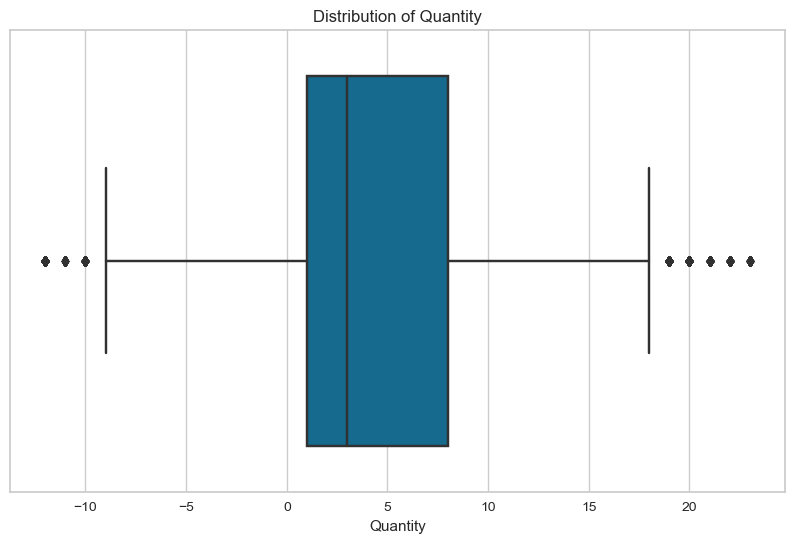

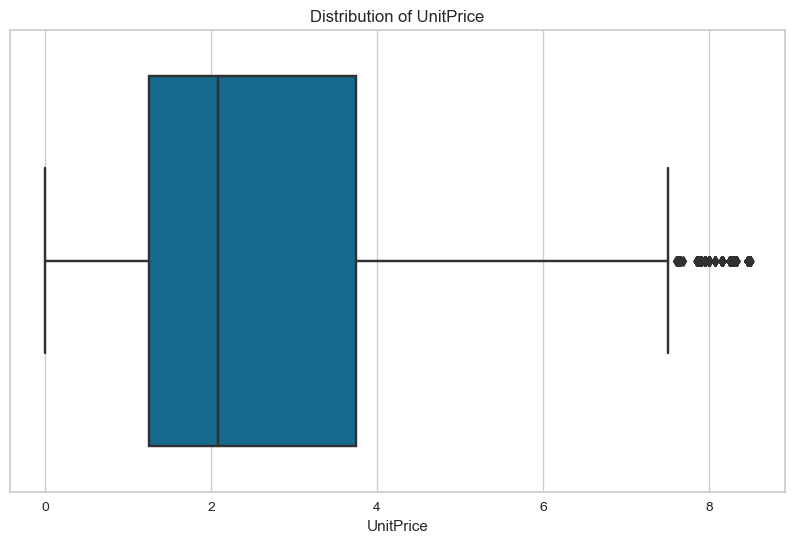

In [12]:
# Visualize the distribution of numerical columns using box plots
plt.figure(figsize=(10,6))
sns.boxplot(x='Quantity', data=data)
plt.title('Distribution of Quantity')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='UnitPrice', data=data)
plt.title('Distribution of UnitPrice')
plt.show()

In [13]:
upprlmt_u=data['UnitPrice'].mean()+3*data['UnitPrice'].std()
lwrlmt_u=data['UnitPrice'].mean()-3*data['UnitPrice'].std()
print(upprlmt_u)
print(lwrlmt_u)

8.550002533686007
-3.1251084442122363


In [14]:
upprlmt=data['Quantity'].mean()+3*data['Quantity'].std()
lwrlmt=data['Quantity'].mean()-3*data['Quantity'].std()
print(upprlmt)
print(lwrlmt)

18.62343070763347
-9.01414527789876


In [15]:
data.loc[(data['Quantity']>upprlmt)|(data['Quantity']>lwrlmt)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09/12/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09/12/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09/12/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09/12/2011 12:50,4.15,12680.0,France


In [16]:
#trimming delete outlier
data1=data.loc[(data['UnitPrice']<upprlmt_u)&(data['UnitPrice']>lwrlmt_u)]



In [17]:
#trimming delete outlier
data1=data1.loc[(data1['Quantity']<upprlmt)&(data1['Quantity']>lwrlmt)]

print("befor removing outlier",data.shape)
print("after removing outlier",data1.shape)

befor removing outlier (444309, 8)
after removing outlier (437935, 8)


###### 3.4. Change The Data type of Features 

We know that InvoiceDate is The day and time when each transaction was generated.But here its data type shows that object so we need to convert the data type to date time format

In [18]:
#data1['InvoiceDate'] = pd.to_datetime(data1['InvoiceDate'],format='mixed')
#data1['InvoiceDate'].info()
data1.loc[:, 'InvoiceDate'] = pd.to_datetime(data1['InvoiceDate'], format='mixed')
data1['InvoiceDate'].info()

<class 'pandas.core.series.Series'>
Index: 437935 entries, 0 to 541908
Series name: InvoiceDate
Non-Null Count   Dtype 
--------------   ----- 
437935 non-null  object
dtypes: object(1)
memory usage: 6.7+ MB


In the dataset data tyoe of customer ID is string so i convert it to objct

In [19]:
data1.loc[:, 'CustomerID'] = data1['CustomerID'].astype(str)
data1['CustomerID'].info()

<class 'pandas.core.series.Series'>
Index: 437935 entries, 0 to 541908
Series name: CustomerID
Non-Null Count   Dtype 
--------------   ----- 
437935 non-null  object
dtypes: object(1)
memory usage: 6.7+ MB


### 4. Feature Engineering

###### 4.1. Adding new feature

In [20]:
data1['InvoiceDate'].info()

<class 'pandas.core.series.Series'>
Index: 437935 entries, 0 to 541908
Series name: InvoiceDate
Non-Null Count   Dtype 
--------------   ----- 
437935 non-null  object
dtypes: object(1)
memory usage: 6.7+ MB


In [21]:
data1['InvoiceDate'] = pd.to_datetime(data1['InvoiceDate'])

# Check the data type of the InvoiceDate column after conversion
print(data1['InvoiceDate'].dtype)

datetime64[ns]


In [22]:
# Date
data1.loc[:, 'Date'] = data1['InvoiceDate'].dt.date

# Time
data1.loc[:, 'Time'] = data1['InvoiceDate'].dt.time

# Hour
data1.loc[:, "Hour"] = data1['InvoiceDate'].dt.strftime('%H')

# Hour to Time of Day
data1.loc[:, 'Time of Day'] = pd.cut(data1['InvoiceDate'].dt.hour, [0,6,12,18,23], labels=['Night','Morning','Afternoon','Evening'], include_lowest=True)

# Month
data1.loc[:, 'Month'] = data1['InvoiceDate'].dt.month_name()

# Year
data1.loc[:, 'Year'] = data1['InvoiceDate'].dt.year

# Week of the Year
data1.loc[:, 'Week of the Year'] = data1['InvoiceDate'].dt.isocalendar().week

# Day of Week
data1.loc[:, 'Day of Week'] = data1['InvoiceDate'].dt.day_name()

In [23]:
# Find the oldest and most recent dates in the dataset
oldest_date = data1['Date'].min()
most_recent_date = data1['Date'].max()

# Print oldest and most recent dates in the dataset
print('Oldest date in dataset: ', oldest_date)
print('Most recent date in dataset: ', most_recent_date)

Oldest date in dataset:  2010-01-12
Most recent date in dataset:  2011-12-10


In [24]:
# Drop the row from the year 2010
index_names =data1[data1['Year']==2010].index
data1.drop(index_names, inplace = True)
data1.drop('Year', axis=1, inplace=True)
data1.shape

(403365, 15)

In [25]:
# Adding new fature to calculate Sales revenue
data1['Sales Revenue']=data1['UnitPrice']*data1['Quantity']
# Check if Sales Revenue is negative
index_names =data1[data1['Sales Revenue']<=0].index
data1.drop(index_names, inplace = True)
data1.drop_duplicates(inplace = True)
data1.shape

(393092, 16)

In [26]:
print('Number of observations after data cleaning: ', data1.shape[0])
print('Number of features after data cleaning: ',data1.shape[1])

Number of observations after data cleaning:  393092
Number of features after data cleaning:  16


In [27]:
data1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Date', 'Time', 'Hour',
       'Time of Day', 'Month', 'Week of the Year', 'Day of Week',
       'Sales Revenue'],
      dtype='object')

In [28]:
data1.to_csv('CleanRetailData_1.csv')

### Visualization

In [29]:
df=pd.read_csv('CleanRetailData_1.csv')

In [30]:
df.columns

Index(['Unnamed: 0', 'InvoiceNo', 'StockCode', 'Description', 'Quantity',
       'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country', 'Date', 'Time',
       'Hour', 'Time of Day', 'Month', 'Week of the Year', 'Day of Week',
       'Sales Revenue'],
      dtype='object')

In [31]:
df.drop(columns=['Unnamed: 0'], inplace=True)


In [32]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Time,Hour,Time of Day,Month,Week of the Year,Day of Week,Sales Revenue
0,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-04-01 10:00:00,1.95,13313.0,United Kingdom,2011-04-01,10:00:00,10,Morning,April,13,Friday,19.5
1,539993,22379,RECYCLING BAG RETROSPOT,5,2011-04-01 10:00:00,2.10,13313.0,United Kingdom,2011-04-01,10:00:00,10,Morning,April,13,Friday,10.5
2,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-04-01 10:00:00,1.25,13313.0,United Kingdom,2011-04-01,10:00:00,10,Morning,April,13,Friday,12.5
3,539993,85099B,JUMBO BAG RED RETROSPOT,10,2011-04-01 10:00:00,1.95,13313.0,United Kingdom,2011-04-01,10:00:00,10,Morning,April,13,Friday,19.5
4,539993,20682,RED RETROSPOT CHILDRENS UMBRELLA,6,2011-04-01 10:00:00,3.25,13313.0,United Kingdom,2011-04-01,10:00:00,10,Morning,April,13,Friday,19.5


###### 5.1. Top 10 Countries with their total order 

In [33]:
# Aggregating on Countries
country_top = df.groupby('Country')['InvoiceNo'].nunique().sort_values(ascending = False).reset_index()
country_top_ten = country_top.head(10)
country_top_ten

,Country,InvoiceNo
0,United Kingdom,14779
1,Germany,391
2,France,340
3,EIRE,241
4,Belgium,88
5,Spain,77
6,Netherlands,57
7,Switzerland,44
8,Portugal,41
9,Australia,38


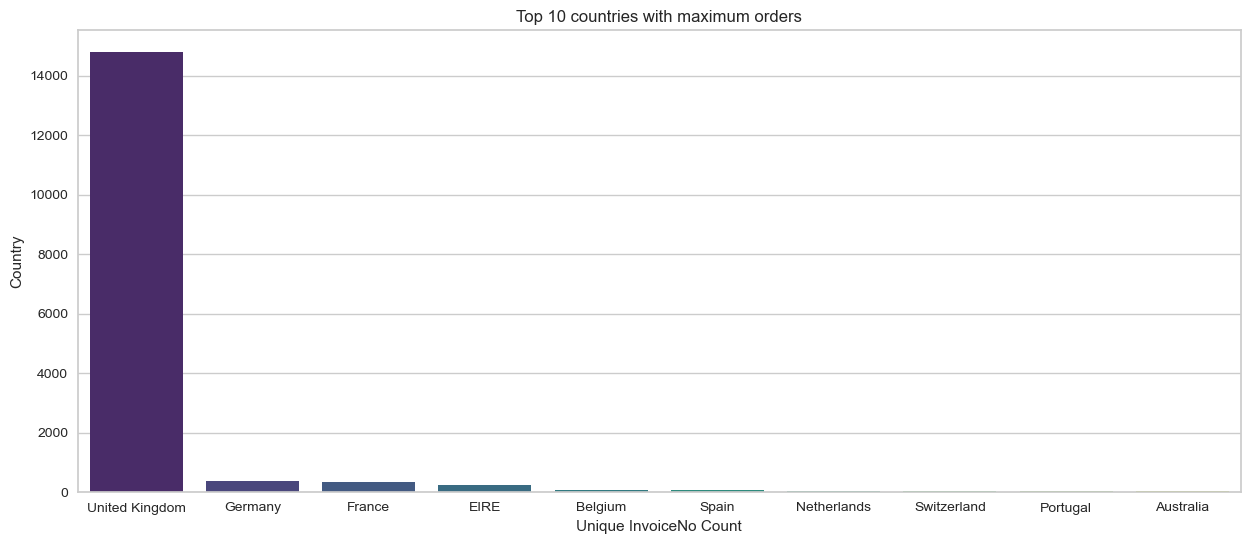

In [34]:
# Plotting
sns.barplot(data = country_top_ten, x ="Country", y = "InvoiceNo", palette ='viridis')
# Labelling
plt.title('Top 10 countries with maximum orders')
plt.xlabel('Unique InvoiceNo Count')
plt.ylabel('Country')
# Set size for plot
fig = plt.gcf()
fig.set_size_inches(15,6)

Observations:
  * The charts shows that UK has far more invoices than the other countrys with 16572 orders
  * Then Germany is in second place with 427 order. That is approximatly 30 times less voices than UK
  * From the analysis the reatil store manager can make necessary steps for the less number of order in other countrys
  * They need a quality website traffic

###### 5.2. Total Sales Revenue for Countries

In [35]:

tsls_rvn=df.groupby('Country')['Sales Revenue'].sum().sort_values(ascending = False).reset_index()
tp10_tsls_rvn=tsls_rvn.head(10)
tp10_tsls_rvn

,Country,Sales Revenue
0,United Kingdom,3656338.074
1,Germany,109646.110
2,France,96253.160
3,EIRE,94983.890
4,Spain,25851.830
5,Belgium,24178.410
6,Switzerland,23568.550
7,Portugal,15240.540
8,Norway,12741.710
9,Netherlands,10670.060


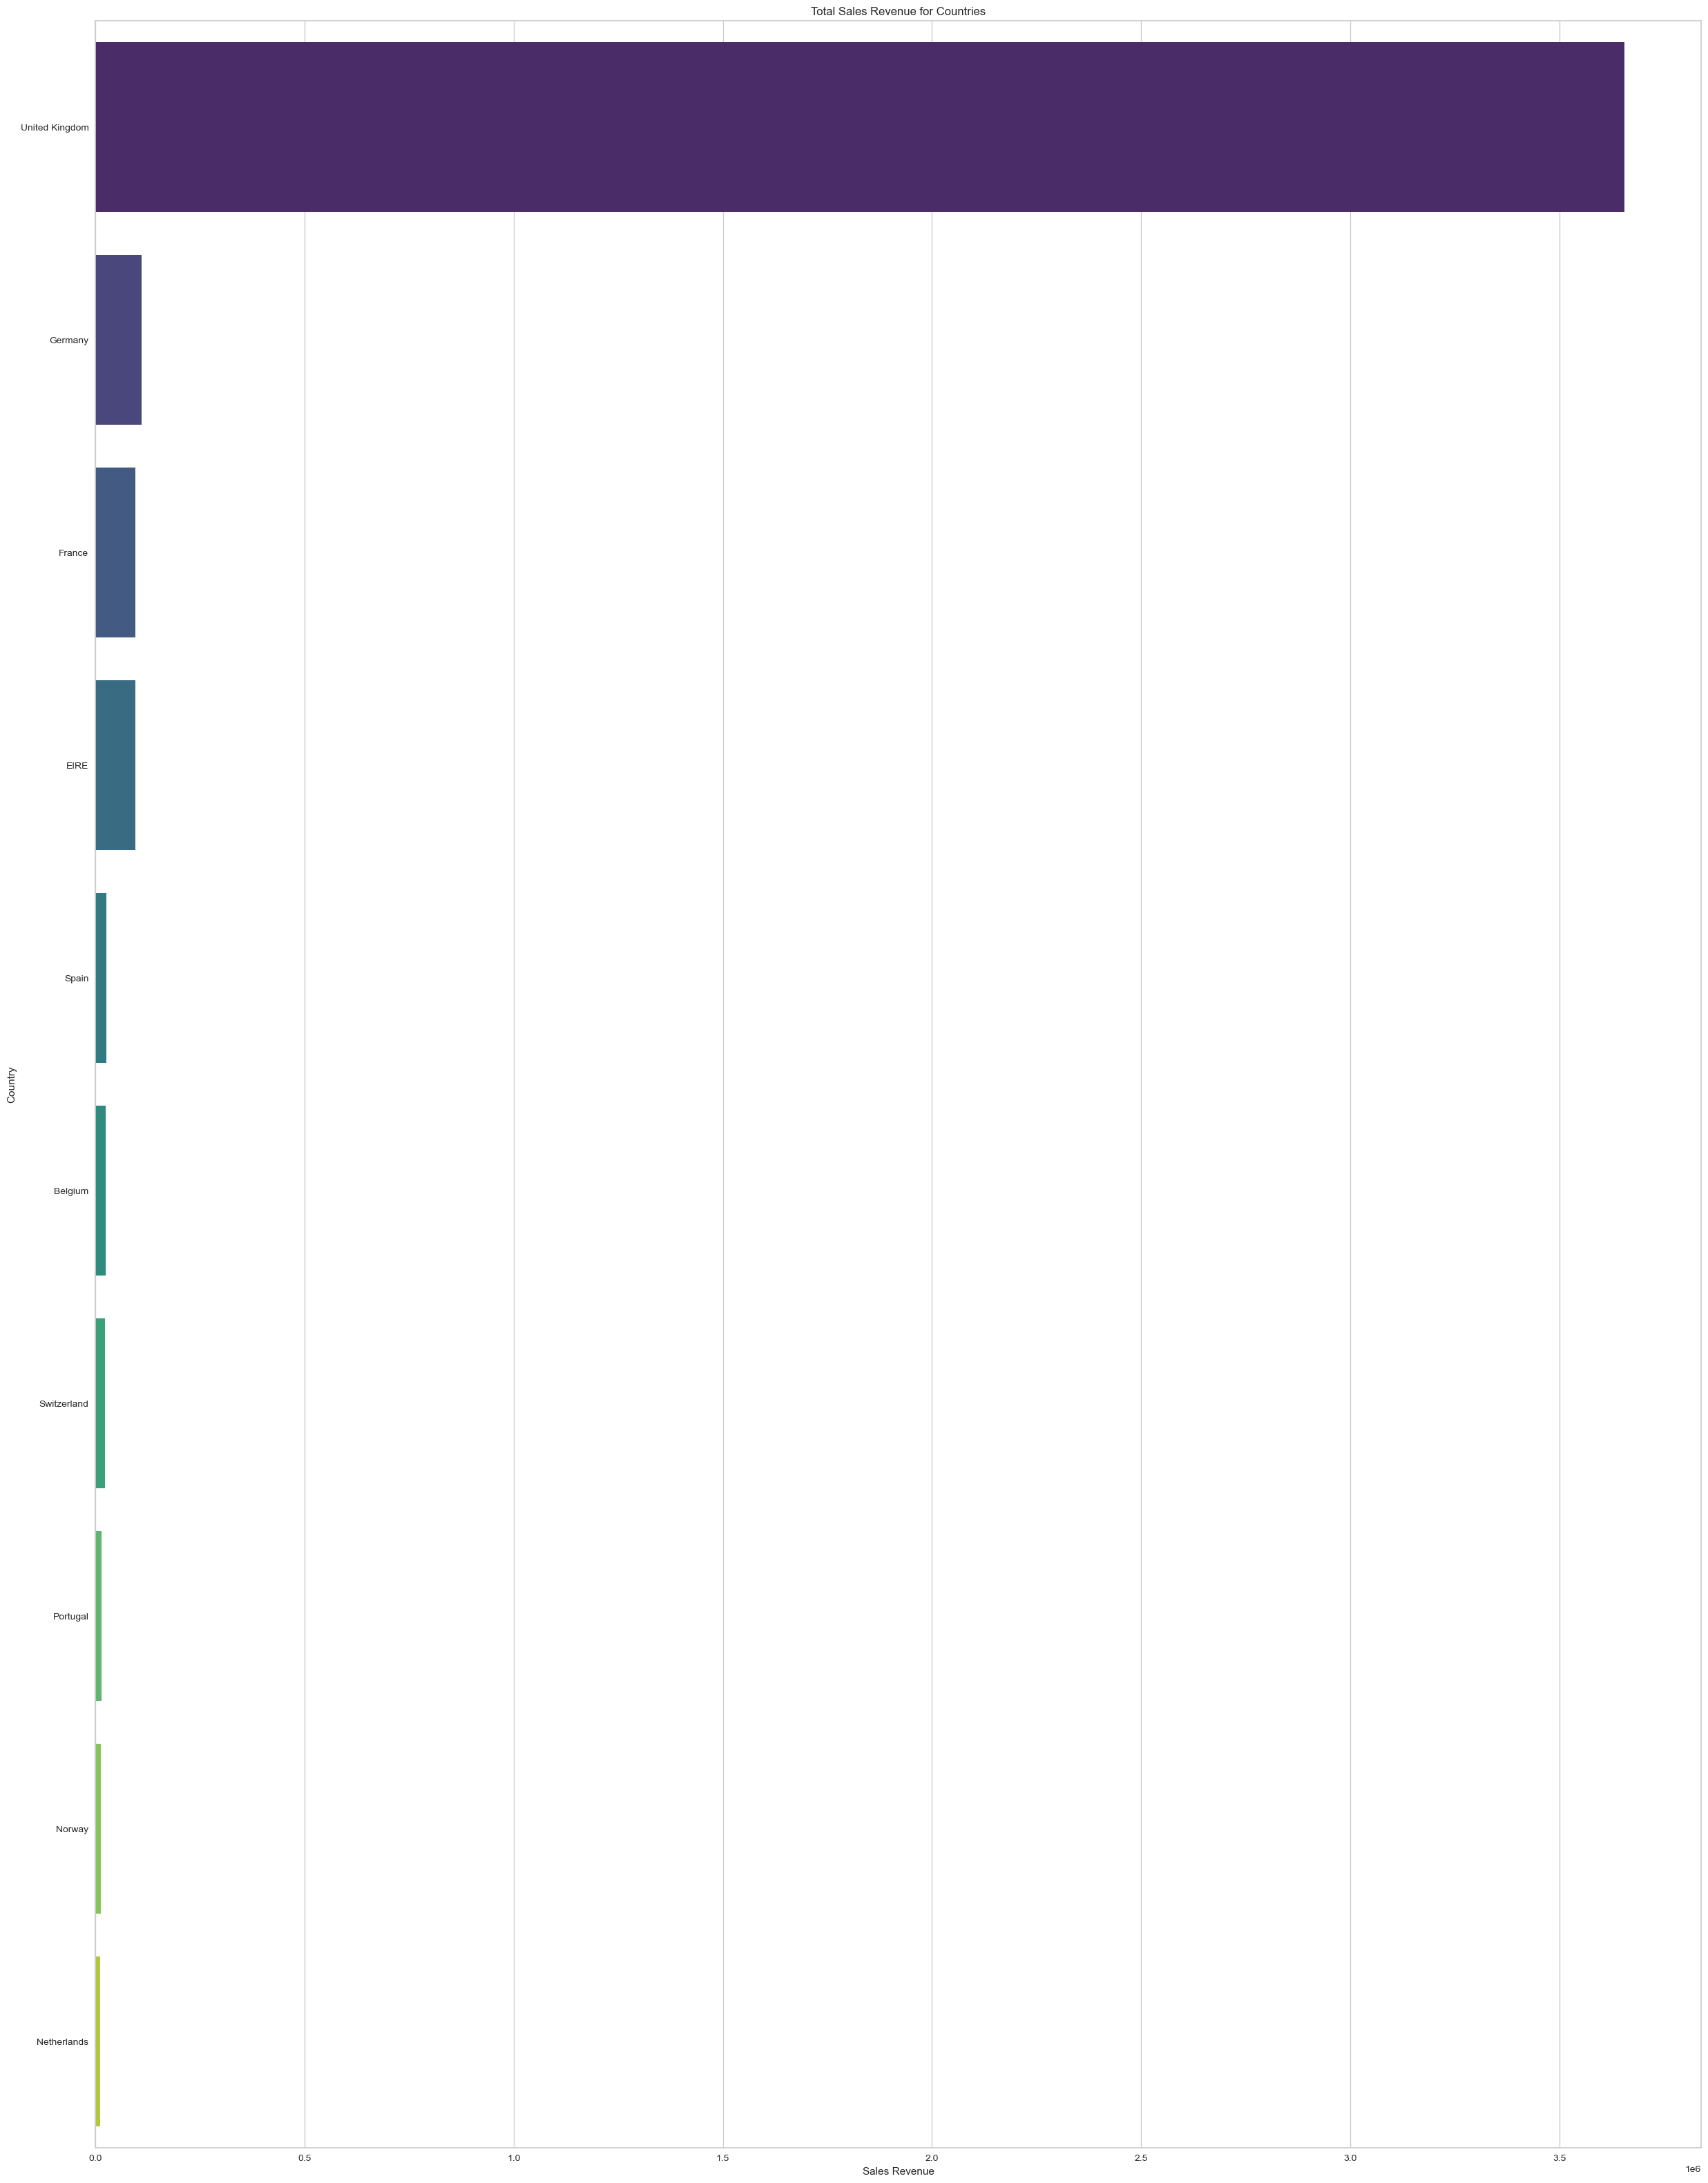

In [36]:
# Plotting
sns.barplot(data =tp10_tsls_rvn, x ="Sales Revenue", y = "Country", palette = 'viridis')
# Labelling
plt.title('Total Sales Revenue for Countries')
plt.ylabel('Country')
plt.xlabel('Sales Revenue')
# Set size for plot
fig = plt.gcf()
fig.set_size_inches(30,40)

###### 5.3. Total Quantity of Items Sold for Countries

In [37]:
qunty_sld=df.groupby('Country')['Quantity'].sum().sort_values(ascending = False).reset_index()
top_10_qnty=qunty_sld.head(10)
top_10_qnty

,Country,Quantity
0,United Kingdom,1664423
1,Germany,53476
2,France,48273
3,EIRE,41791
4,Spain,12481
5,Belgium,12239
6,Switzerland,10651
7,Portugal,7448
8,Norway,5100
9,Italy,4376


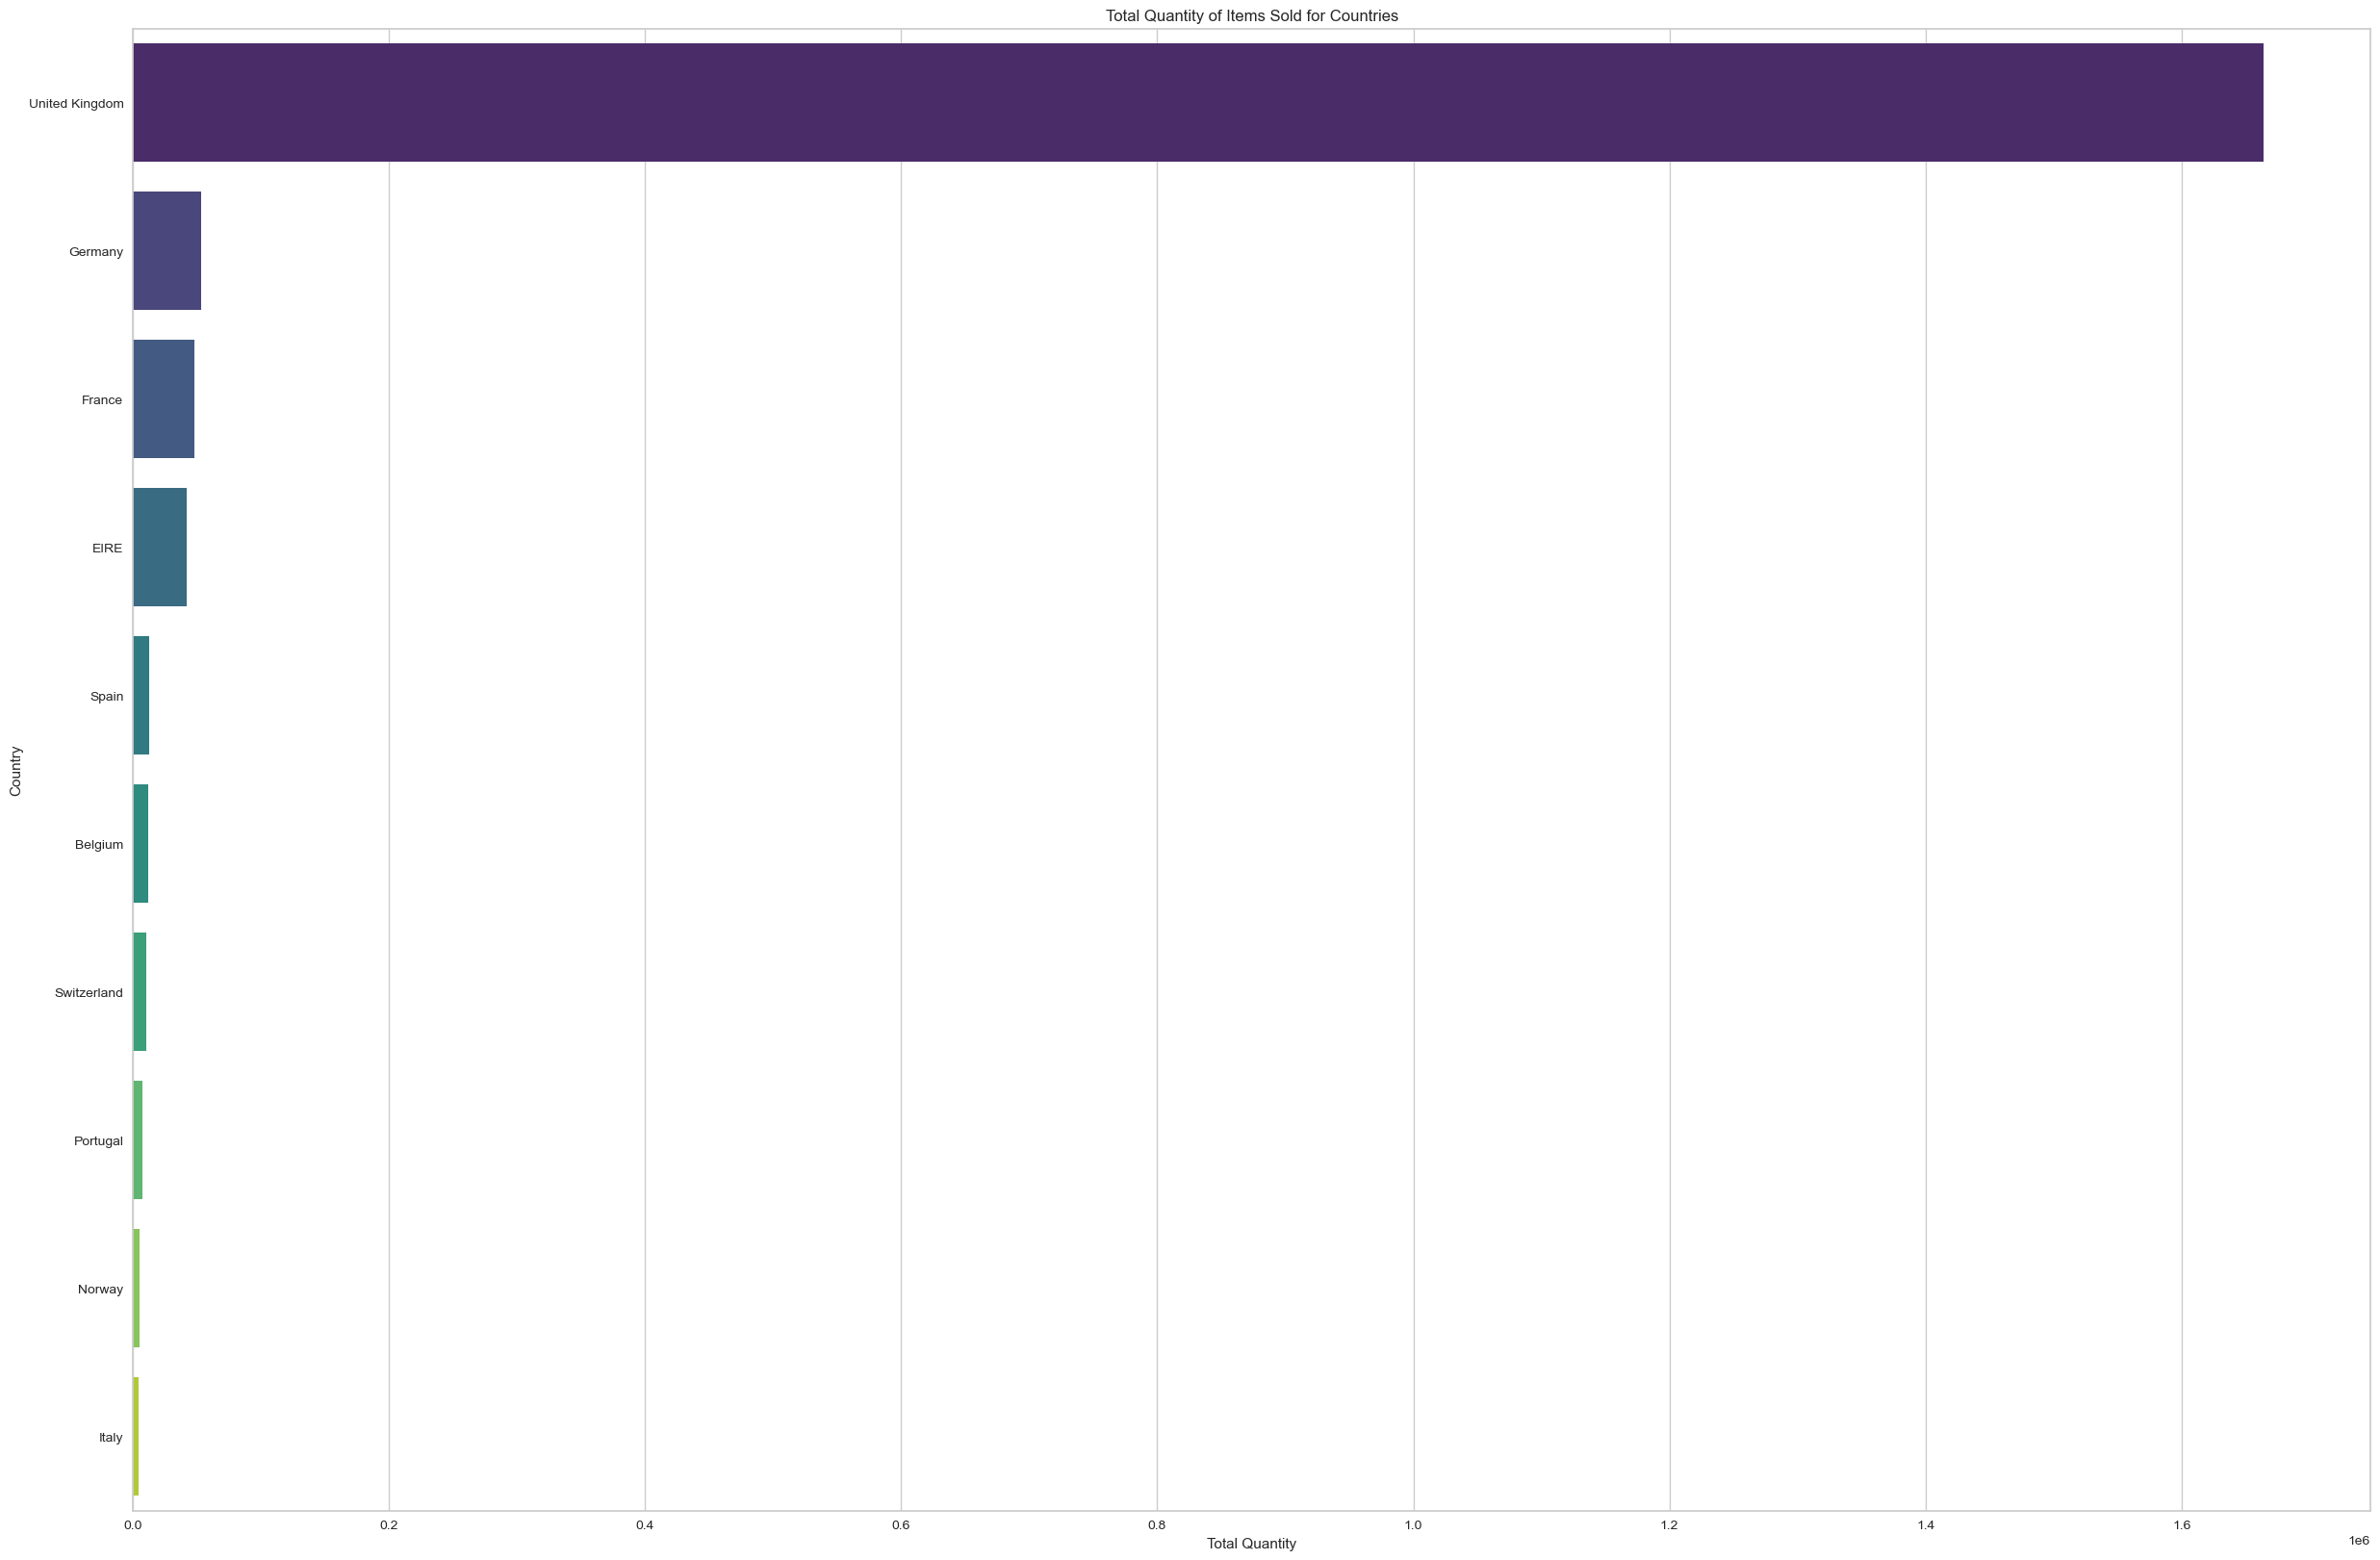

In [38]:
# Plotting
sns.barplot(data =top_10_qnty,x ="Quantity",y = "Country", palette = 'viridis')
# Labelling
plt.title('Total Quantity of Items Sold for Countries')
plt.ylabel('Country')
plt.xlabel('Total Quantity')
#set size for plot
fig = plt.gcf()
fig.set_size_inches(30,20)


###### 5.4  Monthly Statistics

In [39]:
# Function to group on Month/Date/Day of the Week/Week of the Year/Time of the Day
def group_sales_quantity(df_sls, feature):
    df_sls= df_sls[[f'{feature}','Quantity','Sales Revenue']].groupby([f'{feature}']).sum().sort_values(by= 'Sales Revenue', ascending = False).reset_index()
    return df_sls

In [40]:
# Get monthly stats dataframe
monthly_stats = group_sales_quantity(df, 'Month')

Text(0.5, 0, 'Total Sales Revenue')

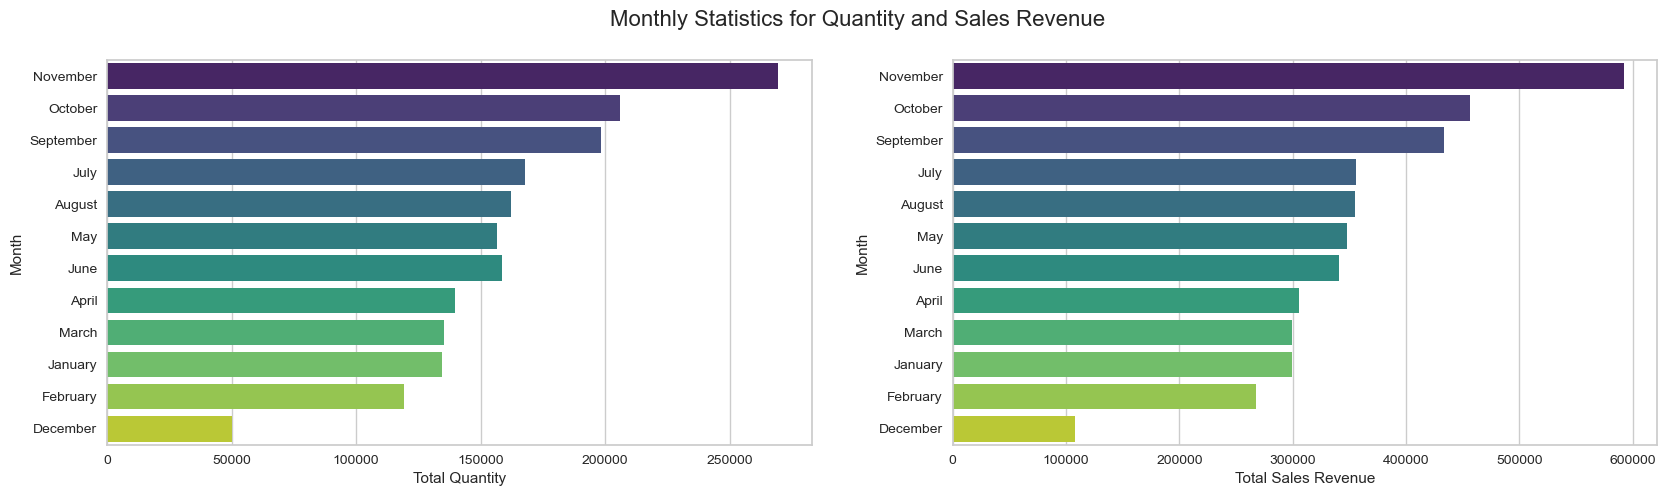

In [41]:
# Plot
fig, ax = plt.subplots(1, 2, figsize = (20, 5))
fig.suptitle('Monthly Statistics for Quantity and Sales Revenue', fontsize=16)

# Distribution of price, after outlier handling
sns.barplot(data = monthly_stats, x = "Quantity", y = "Month" , palette = 'viridis', ax = ax[0])
ax[0].set_xlabel('Total Quantity')

# Log transformation and handling neg values with log(1+x)
sns.barplot(data = monthly_stats, x = "Sales Revenue", y = "Month", palette = 'viridis', ax = ax[1])
ax[1].set_xlabel('Total Sales Revenue')

Observations:

 The Monthly statistics for November is the highest due to the popularity of Black Friday events [affected] spending patterns in the lead up to Christmas. This causes more volatile monthly movements in seasonally adjusted data.There were rises in all retail industries in November, but it was spending on discretionary goods boosted by Black Friday sales that drove most of the increase

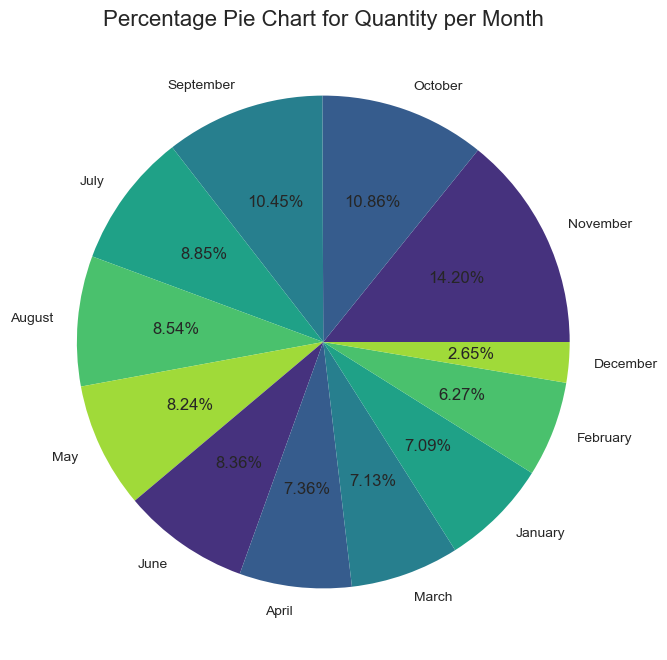

In [42]:
# Colour palette
palette_color = sns.color_palette('viridis')

# Quantity per month
plt.pie(monthly_stats['Quantity'], labels = monthly_stats['Month'], colors=palette_color, autopct='%.02f%%')
plt.title('Percentage Pie Chart for Quantity per Month', fontsize=16)

# Displaying chart
fig = plt.gcf()
fig.set_size_inches(8,8)
plt.show()

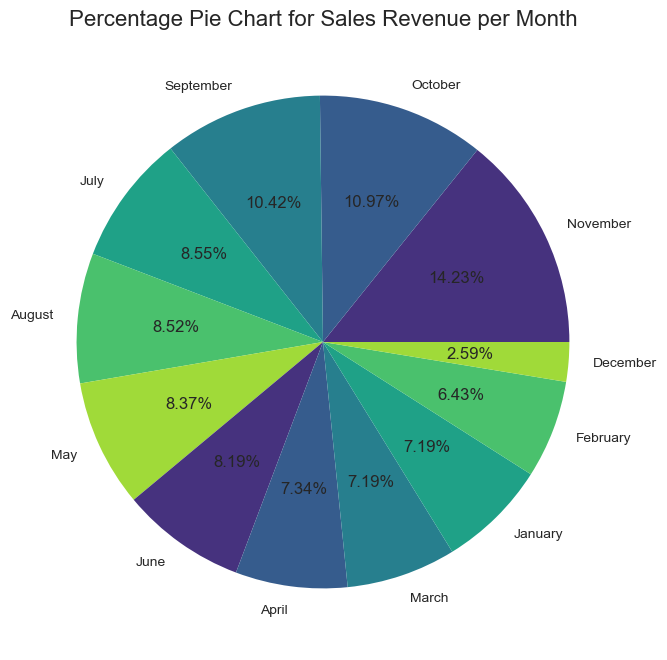

In [43]:
# Sales Revenue per month
plt.pie(monthly_stats['Sales Revenue'], labels = monthly_stats['Month'], colors=palette_color, autopct='%.02f%%')
plt.title('Percentage Pie Chart for Sales Revenue per Month', fontsize=16)

# Displaying chart
fig = plt.gcf()
fig.set_size_inches(8,8)
plt.show()

###### Observation:

   * Highest sales (by revenue and quantity) has been noted during the Fall season, which are the month of September,         October, November
   * Lowest percentage of sales (by revenue and quantity) has been noted during the Winter season (January, February, March,    April) where people are unable to leave the house due to harsh weather


###### 5.5 Daily Statistics

Text(0, 0.5, 'Day of Week')

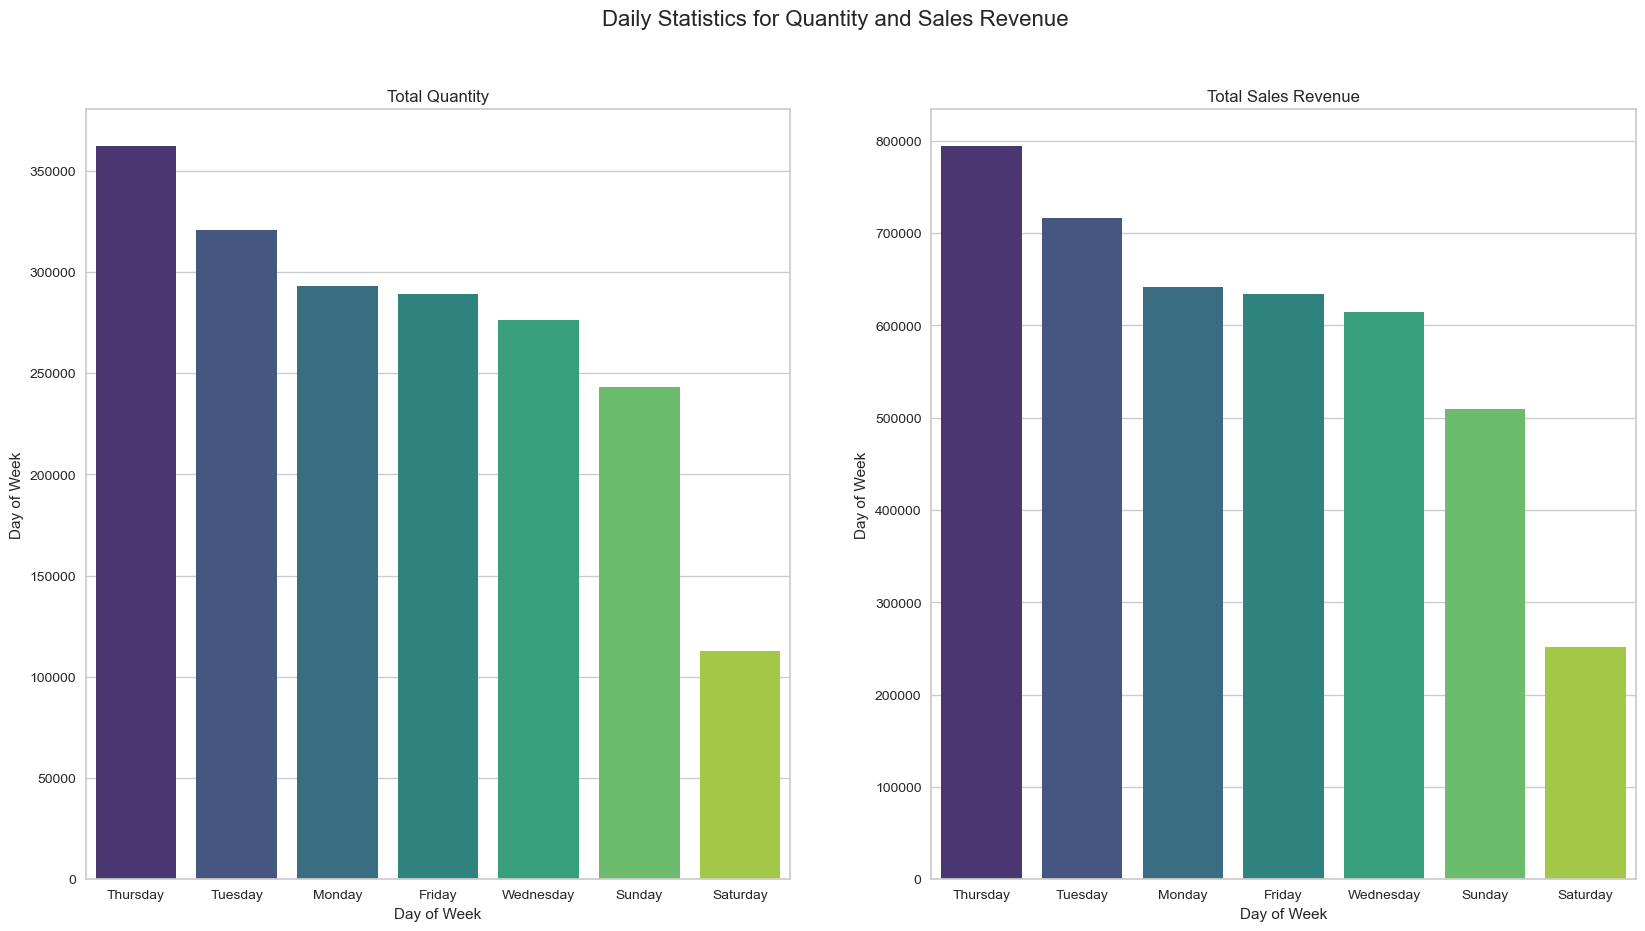

In [44]:
# Get daily stats dataframe
daily_stats = group_sales_quantity(df, 'Day of Week')
# Plot
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
fig.suptitle('Daily Statistics for Quantity and Sales Revenue', fontsize=16)

sns.barplot(data = daily_stats, x = "Day of Week", y = "Quantity" , palette = 'viridis', ax = ax[0])
ax[0].set_title('Total Quantity')
ax[0].set_ylabel('Day of Week')

sns.barplot(data = daily_stats, x = "Day of Week", y = "Sales Revenue", palette = 'viridis', ax = ax[1])
ax[1].set_title('Total Sales Revenue')
ax[1].set_ylabel('Day of Week')

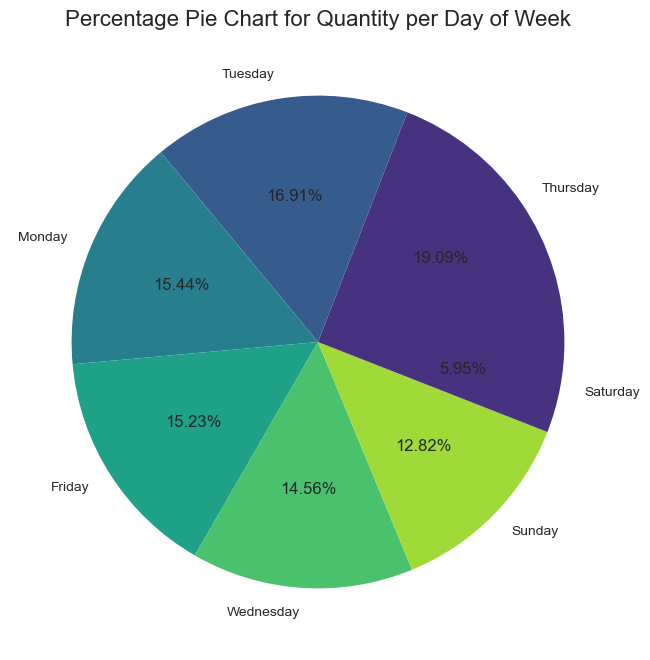

In [45]:
# Colour palette
palette_color = sns.color_palette('viridis')

# Quantity per day of week
plt.pie(daily_stats['Quantity'], labels = daily_stats['Day of Week'], colors=palette_color, autopct='%.02f%%')
plt.title('Percentage Pie Chart for Quantity per Day of Week', fontsize=16)

# Displaying chart
fig = plt.gcf()
fig.set_size_inches(8,8)
plt.show()


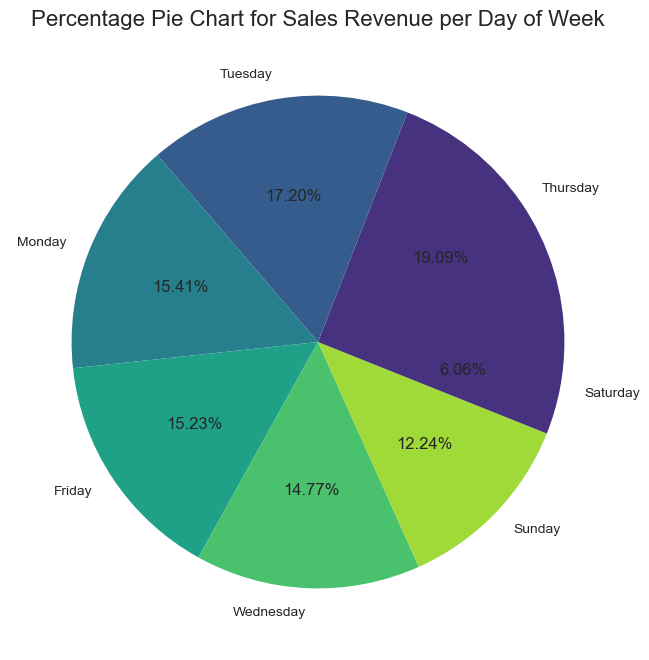

In [46]:
# Sales Revenue per Day of Week
plt.pie(daily_stats['Sales Revenue'], labels = daily_stats['Day of Week'], colors=palette_color, autopct='%.02f%%')
plt.title('Percentage Pie Chart for Sales Revenue per Day of Week', fontsize=16)

# Displaying chart
fig = plt.gcf()
fig.set_size_inches(8,8)
plt.show()

###### Observation:

* People buy more on Thursdays to prepare for the weekend, followed by Tuesday to prepare for the week ahead
* Least sale is noted for Sunday

In [47]:
# Top 10 customers without 'Guest Customer'
top_customers =df[df["CustomerID"] != 0].groupby("CustomerID")["InvoiceNo"].nunique().sort_values(ascending = False).reset_index().head(11)
top_customers

,CustomerID,InvoiceNo
0,14911.0,179
1,12748.0,157
2,17841.0,117
3,15311.0,82
4,14606.0,82
5,13089.0,74
6,12971.0,65
7,14527.0,50
8,15039.0,44
9,17811.0,39


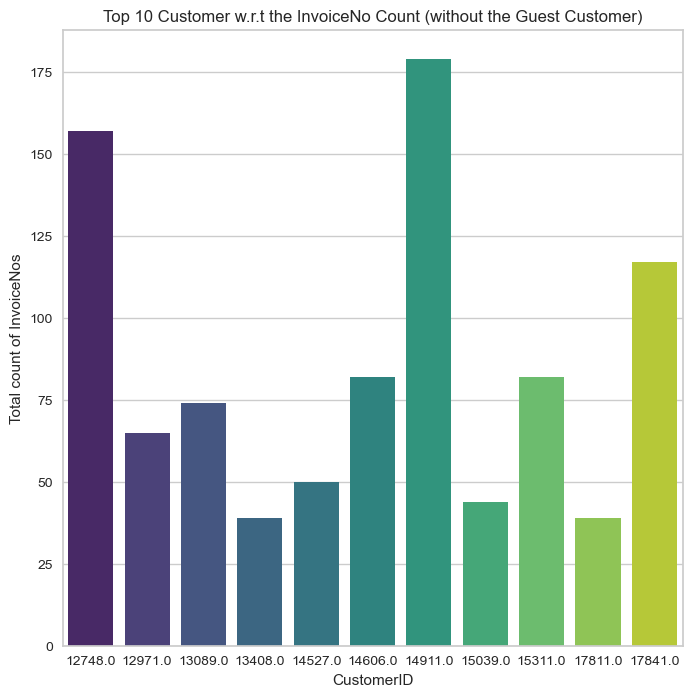

In [48]:
#plot
sns.barplot(data =top_customers, x = "CustomerID", y = "InvoiceNo" , palette = 'viridis')
plt.title('Top 10 Customer w.r.t the InvoiceNo Count (without the Guest Customer)')
plt.ylabel('Total count of InvoiceNos')
plt.xlabel('CustomerID')

# Displaying chart
fig = plt.gcf()
fig.set_size_inches(8,8)
plt.show()

###### 5.7. Top products

5.7.1. Top products by sold Quantity

In [49]:
# Top 10 Product Description by Quantity
top_products_qty = group_sales_quantity(df, 'Description').sort_values(ascending=False, by = "Quantity").reset_index(drop=True)
top_products_qty.drop('Sales Revenue', axis=1, inplace=True)
top_products_qty.head()


,Description,Quantity
0,ASSORTED COLOUR BIRD ORNAMENT,10156
1,JUMBO BAG RED RETROSPOT,9716
2,WHITE HANGING HEART T-LIGHT HOLDER,9613
3,LUNCH BAG RED RETROSPOT,7705
4,JAM MAKING SET PRINTED,6665


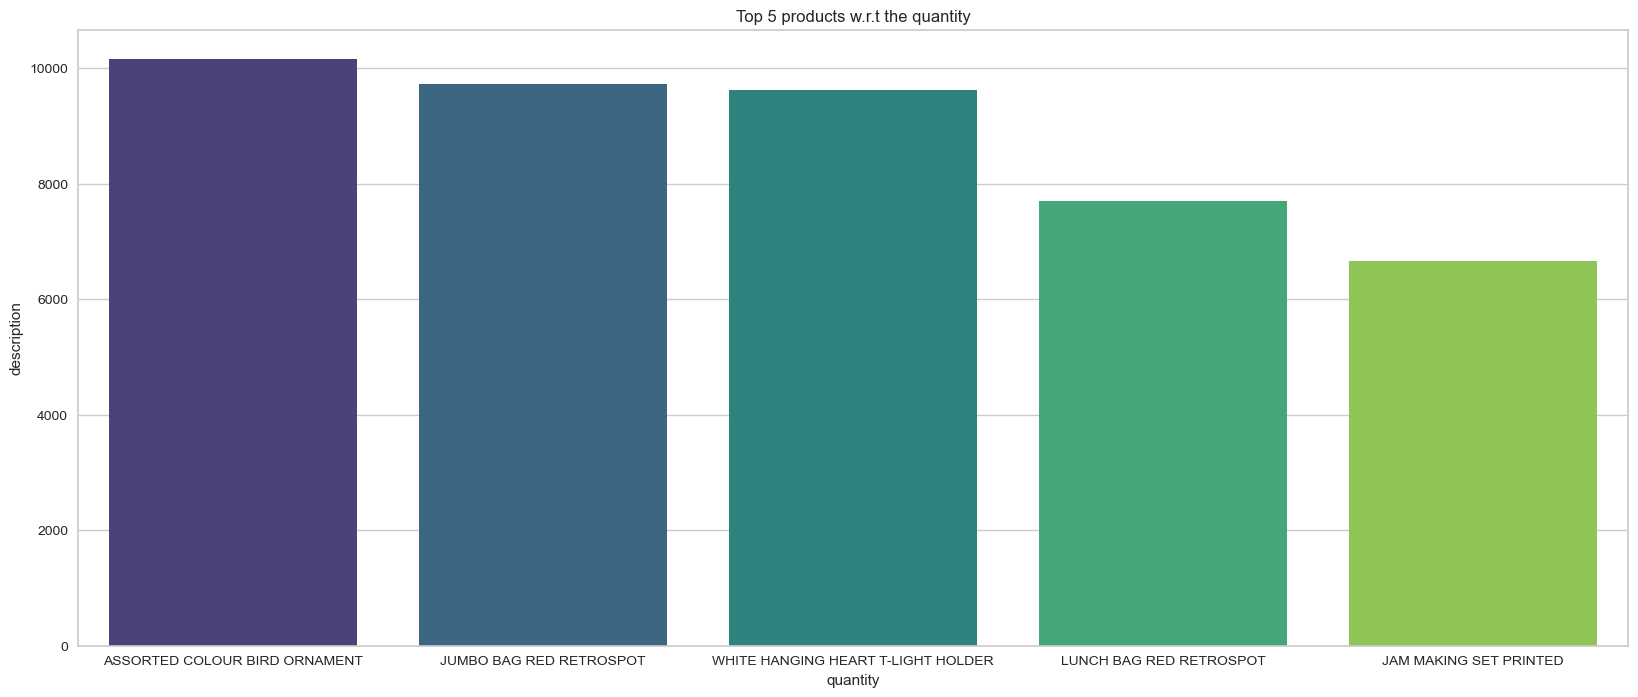

In [50]:
sns.barplot(data =top_products_qty.head(), x = "Description", y = "Quantity" , palette = 'viridis')
plt.title('Top 5 products w.r.t the quantity')
plt.ylabel('description')
plt.xlabel('quantity')

# Displaying chart
fig = plt.gcf()
fig.set_size_inches(20,8)
plt.show()

5.7.2 Top products by Sales Revenue

In [51]:
# Top 10 Product Description by Sales Revenue
top_products_revenue = group_sales_quantity(df, 'Description').sort_values(ascending=False, by = "Sales Revenue").reset_index(drop=True)
top_products_revenue.drop('Quantity', axis=1, inplace=True)
top_products_revenue.head()

,Description,Sales Revenue
0,PARTY BUNTING,32262.44
1,WHITE HANGING HEART T-LIGHT HOLDER,29866.39
2,JUMBO BAG RED RETROSPOT,23028.77
3,SPOTTY BUNTING,22060.05
4,JAM MAKING SET WITH JARS,21608.52


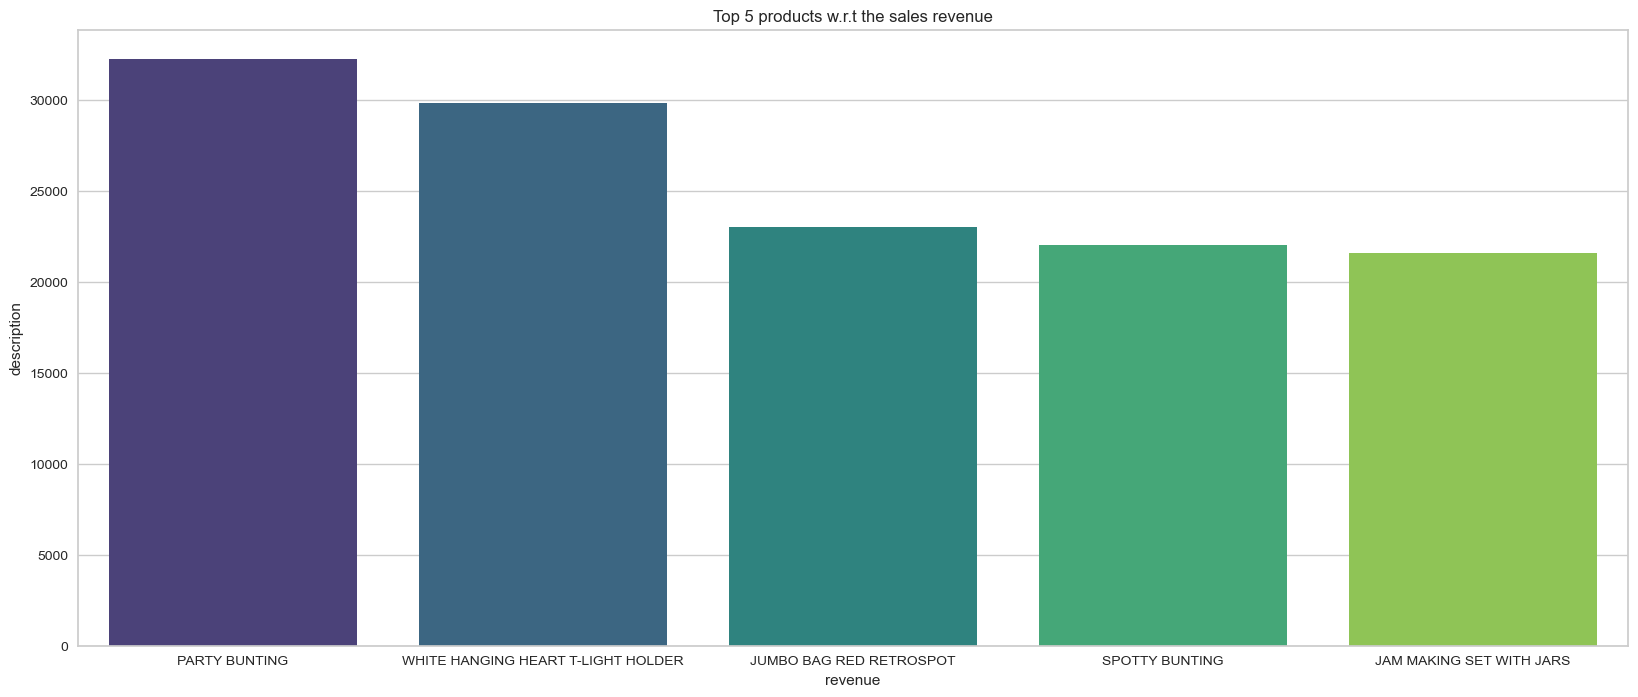

In [52]:
sns.barplot(data =top_products_revenue.head(), x = "Description", y = "Sales Revenue" , palette = 'viridis')
plt.title('Top 5 products w.r.t the sales revenue')
plt.ylabel('description')
plt.xlabel('revenue')

# Displaying chart
fig = plt.gcf()
fig.set_size_inches(20,8)
plt.show()

### 6. Market Basket analysis

Market Basket Analysis is one of the key techniques used by large retailers to uncover associations between items. It works by looking for combinations of items that occur together frequently in transactions. To put it another way, it allows retailers to identify relationships between the items that people buy. Association Rules are widely used to analyze retail basket or transaction data, and are intended to identify strong rules discovered in transaction data using measures of interestingness, based on the concept of strong rules.

In [53]:
# List of all countries
country_list = list(dict(df['Country'].value_counts()).keys())
print('List of all countries:', country_list)

List of all countries: ['United Kingdom', 'Germany', 'France', 'EIRE', 'Spain', 'Belgium', 'Switzerland', 'Portugal', 'Norway', 'Italy', 'Channel Islands', 'Netherlands', 'Finland', 'Australia', 'Cyprus', 'Unspecified', 'Austria', 'Poland', 'Denmark', 'Israel', 'Sweden', 'Hong Kong', 'USA', 'Singapore', 'Greece', 'Iceland', 'Canada', 'Malta', 'Japan', 'United Arab Emirates', 'RSA', 'European Community', 'Lebanon', 'Brazil', 'Bahrain', 'Saudi Arabia', 'Czech Republic']


In [54]:
# Function that filters the data frame based on country name

def choose_country(country = "all", data = df):
    if country == "all":
        return data
    else:
        temp_df = data[data["Country"] == country]
        temp_df.reset_index(drop= True, inplace= True)
        return temp_df

Most of the transaction come from UK and so, we limit the data that we will use to only the transaction that come from UK

In [55]:
uk_retail = choose_country("United Kingdom")
uk_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Time,Hour,Time of Day,Month,Week of the Year,Day of Week,Sales Revenue
0,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-04-01 10:00:00,1.95,13313.0,United Kingdom,2011-04-01,10:00:00,10,Morning,April,13,Friday,19.5
1,539993,22379,RECYCLING BAG RETROSPOT,5,2011-04-01 10:00:00,2.10,13313.0,United Kingdom,2011-04-01,10:00:00,10,Morning,April,13,Friday,10.5
2,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-04-01 10:00:00,1.25,13313.0,United Kingdom,2011-04-01,10:00:00,10,Morning,April,13,Friday,12.5
3,539993,85099B,JUMBO BAG RED RETROSPOT,10,2011-04-01 10:00:00,1.95,13313.0,United Kingdom,2011-04-01,10:00:00,10,Morning,April,13,Friday,19.5
4,539993,20682,RED RETROSPOT CHILDRENS UMBRELLA,6,2011-04-01 10:00:00,3.25,13313.0,United Kingdom,2011-04-01,10:00:00,10,Morning,April,13,Friday,19.5


In [56]:
uk_retail.shape

(364590, 16)

###### 6.1. Create basket

   * We now create the basket data that will contain the Quantity of each items bought per transaction (InvoiceNo)
   * This dataframe is basically the ‘basket’ that our customers ‘carry on’ to the cashier in our shop
   * It shows us how much this customer / transaction (InvoiveNo) bought a particular item
   * If the number is 0, then this customer didn’t buy that particular item
   * If it shows another value (12 for instances), it means that the customer has bought as many as 12 items.


In [57]:
basket_uk = uk_retail.groupby(['InvoiceNo', 'Description']).sum()['Quantity'].unstack().reset_index().fillna(0).set_index('InvoiceNo')
basket_uk.head()

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,TRELLIS COAT RACK,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,...,ZINC PLANT POT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
539993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
540001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
540002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
540003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
540005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###### 6.2 Encode

* In market basket analysis, the number of each item bought is not really important
* The important one is whether an item is bought or not, because, we only would like to know, what is the association of buying   some items and buying some others
* So we encode the basket data into a binary data that shows whether an items is bought (1) or not (0)

In [58]:
basket_encoded =basket_uk.applymap(lambda x: 1 if x > 0 else 0)
basket_encoded.head()

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,TRELLIS COAT RACK,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,...,ZINC PLANT POT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
539993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###### 6.3. Filter transactions with more than 1 items

   In market basket analysis, we are going to uncover the association between 2 or more items that is bought according to historical data

In [59]:
# We will filter out transactions that have less than 2 items 
basket_uk_encoded_filtered =basket_encoded[(basket_encoded > 0).sum(axis=1) >= 2] # Columnwise sum of encoding should be >= 2
basket_uk_encoded_filtered.head()

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,TRELLIS COAT RACK,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,...,ZINC PLANT POT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
539993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540013,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###### 6.4. Apriori Algorithm

* Apriori algorithm is simply used to find the frequently bought items in the dataset
* In applying apriori algorithm, we are able to define the frequent data that we wanted by giving the support value
* Here we define frequently bought item as item that is bought as many as 2% out of the whole transaction, it means I will give   the support value of 0.02

In [60]:
frequent_itemsets = apriori(basket_uk_encoded_filtered, min_support=0.02, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.020466,(3 PIECE SPACEBOY COOKIE CUTTER SET)
1,0.027776,(3 STRIPEY MICE FELTCRAFT)
2,0.024560,(4 TRADITIONAL SPINNING TOPS)
3,0.053212,(6 RIBBONS RUSTIC CHARM)
4,0.030480,(60 TEATIME FAIRY CAKE CASES)
...,...,...
411,0.032088,"(WOODEN FRAME ANTIQUE WHITE , WOODEN PICTURE F..."
412,0.032308,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY..."
413,0.020466,"(JUMBO SHOPPER VINTAGE RED PAISLEY, JUMBO BAG ..."
414,0.021343,"(JUMBO STORAGE BAG SUKI, JUMBO BAG PINK POLKAD..."


###### 6.5. Assocition Rule Mining
* After applying the apriori algorithm and finding the frequently bought item, it is now the time for us to apply the association rules
* From association rules, we could extract information and discover knowledge about which items are more effective to be sold together

In [61]:
# Create Association Rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Sort values based on lift
rules = rules.sort_values("lift",ascending=False).reset_index(drop= True)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(SMALL MARSHMALLOWS PINK BOWL),(SMALL DOLLY MIX DESIGN ORANGE BOWL),0.028360,0.032892,0.021563,0.760309,23.115092,0.020630,4.034815,0.984664
1,(SMALL DOLLY MIX DESIGN ORANGE BOWL),(SMALL MARSHMALLOWS PINK BOWL),0.032892,0.028360,0.021563,0.655556,23.115092,0.020630,2.820889,0.989278
2,"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",(PINK REGENCY TEACUP AND SAUCER),0.043418,0.046634,0.032308,0.744108,15.956329,0.030283,3.725654,0.979873
3,(PINK REGENCY TEACUP AND SAUCER),"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",0.046634,0.043418,0.032308,0.692790,15.956329,0.030283,3.113772,0.983179
4,(GREEN REGENCY TEACUP AND SAUCER),"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",0.058841,0.035962,0.032308,0.549068,15.267894,0.030192,2.137880,0.992928
...,...,...,...,...,...,...,...,...,...,...
209,(JUMBO BAG RED RETROSPOT),(LUNCH BAG BLACK SKULL.),0.102770,0.075433,0.021343,0.207681,2.753187,0.013591,1.166913,0.709723
210,(NATURAL SLATE HEART CHALKBOARD ),(WHITE HANGING HEART T-LIGHT HOLDER),0.078430,0.117535,0.024706,0.315005,2.680086,0.015488,1.288278,0.680228
211,(WHITE HANGING HEART T-LIGHT HOLDER),(NATURAL SLATE HEART CHALKBOARD ),0.117535,0.078430,0.024706,0.210199,2.680086,0.015488,1.166838,0.710371
212,(JUMBO BAG RED RETROSPOT),(WHITE HANGING HEART T-LIGHT HOLDER),0.102770,0.117535,0.024340,0.236842,2.015073,0.012261,1.156333,0.561439


Observation:

Lift:

* We see that WOODEN HEART CHRISTMAS SCANDINAVIAN and WOODEN STAR CHRISTMAS SCANDINAVIAN are the items that has the highest association each other since these two items has the highest “lift” value
* The higher the lift value, the higher the association between the items will be

Support:

* The support value of WOODEN HEART CHRISTMAS SCANDINAVIAN and WOODEN STAR CHRISTMAS SCANDINAVIAN are 0.02319% which means there are 2.319% out of total transaction that these 2 items were sold together

Confidence:

* From the confidence, we could even extract more information, since the confidence value is influenced by the antecedent and consequent
* If the antecedent is higher than the consequent, then the rule that will be applied is rule number 1 (not number 2)
* In this case, the consequent value is higher than the antecedent value
* It means we will apply rule number 2 which is WOODEN STAR CHRISTMAS SCANDINAVIAN → WOODEN HEART CHRISTMAS SCANDINAVIAN
* In a more detail explanation, it means that a customer will tend to buy WOODEN HEART CHRISTMAS SCANDINAVIAN AFTER they buy WOODEN STAR CHRISTMAS SCANDINAVIAN, not in the other way around
* This could be a very valuable information, because we are now aware which products should we put the discounts on. We could give a discounts on WOODEN HEART CHRISTMAS SCANDINAVIAN if a customer buy WOODEN STAR CHRISTMAS SCANDINAVIAN.

In [62]:
rules.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         214 non-null    object 
 1   consequents         214 non-null    object 
 2   antecedent support  214 non-null    float64
 3   consequent support  214 non-null    float64
 4   support             214 non-null    float64
 5   confidence          214 non-null    float64
 6   lift                214 non-null    float64
 7   leverage            214 non-null    float64
 8   conviction          214 non-null    float64
 9   zhangs_metric       214 non-null    float64
dtypes: float64(8), object(2)
memory usage: 16.8+ KB


In [63]:
# Save rules dataframe for next steps
rules.to_csv('Rules_1.csv')

###### 7. Product Recommendation based on Association Rules

* The product recommendation part of this project is going to make use of the Association Rules that where uncovered in the Market Basket Analysis section
* Product recomentation is basically one of the advantages of Market Basket Analysis where you can recommend to customers products that are in the same itemsets as the customer's current products

In [64]:
# List of all products
product_catalog = list(uk_retail['Description'].unique())
print(f'There are {len(product_catalog)} unique products in the UK marketplace.')


There are 3661 unique products in the UK marketplace.


In [65]:
def remove_from_list(y, item_to_search):
    newlist = list()
    for i in y:
        if i not in item_to_search:
            newlist.append(i)
    return newlist

In [66]:


def search_list(item_to_search, list_to_search = rules['antecedents']):
    print(item_to_search)
    max_lift = 0
    item_to_recommend = ''
    for i, item in enumerate(list_to_search):
        if set(list(item_to_search)).issubset(set(list(item))):
            if rules['lift'][i] > max_lift:
                max_lift = rules['lift'][i]
                y = list(rules['antecedents'][i])
                x = remove_from_list(y, item_to_search)
                item_to_recommend = list(rules['consequents'][i]) + x
    
    if item_to_recommend == '':
        item_to_recommend = []
        print(f"Oops! No product recommendations available right now!: {item_to_recommend}")
    else:
        print(f"People who bought this also bought: {item_to_recommend}")
    return item_to_search, item_to_recommend


In [67]:
dict_to_store = {}
for i in range(len(product_catalog)):
    key, value = search_list([product_catalog[i]])
    dict_to_store[key[0]] = value

['JUMBO BAG PINK POLKADOT']
People who bought this also bought: ['JUMBO STORAGE BAG SUKI', 'JUMBO BAG RED RETROSPOT']
['RECYCLING BAG RETROSPOT ']
People who bought this also bought: ['JUMBO BAG RED RETROSPOT']
['RED RETROSPOT SHOPPER BAG']
Oops! No product recommendations available right now!: []
['JUMBO BAG RED RETROSPOT']
People who bought this also bought: ['JUMBO STORAGE BAG SUKI', 'JUMBO SHOPPER VINTAGE RED PAISLEY']
['RED RETROSPOT CHILDRENS UMBRELLA']
Oops! No product recommendations available right now!: []
['JAM MAKING SET PRINTED']
People who bought this also bought: ['JAM MAKING SET WITH JARS']
['RECIPE BOX RETROSPOT ']
Oops! No product recommendations available right now!: []
['CHILDRENS APRON APPLES DESIGN']
Oops! No product recommendations available right now!: []
['PEG BAG APPLES DESIGN']
Oops! No product recommendations available right now!: []
['COFFEE MUG APPLES DESIGN']
Oops! No product recommendations available right now!: []
['COFFEE MUG PEARS  DESIGN']
Oops! No p

In [68]:
dict_to_store['JUMBO BAG RED RETROSPOT']# customer buy JUMBO BAG RED RETROSPOT which item they broght together

['JUMBO STORAGE BAG SUKI', 'JUMBO SHOPPER VINTAGE RED PAISLEY']

convert it to json file.The reason for converting the dictionary to a JSON file is to store the data in a format that can be easily read and manipulated .JSON is a popular data interchange format, and using it allows for easy interoperability between different programming languages and platforms. Additionally, it provides a human-readable format, making it easy for developers to inspect and modify the data manually if needed.


In [69]:
import json

json_file = json.dumps(dict_to_store)
# open file for writing, "w" 
f = open("item_sets.json","w")
# write json object to file
f.write(json_file)



130629

In [70]:
# close file
f.close()
# Opening JSON file
with open('item_sets.json') as json_file:
    data = json.load(json_file)


In [71]:
for a in data['JUMBO BAG PINK POLKADOT']:
    print(a)

JUMBO STORAGE BAG SUKI
JUMBO BAG RED RETROSPOT


### 8. Customer-Segmentation-Based-On-RFM

###### 8.1. What is RFM Analysis?

* It is a customer segmentation technique that uses past purchase behavior to segment customers, so that you can market to those customers more effectively
* To perform RFM analysis, we divide customers into four equal groups according to the distribution of values for recency, frequency, and monetary value
  1.Recency (R): Time since last purchase
  2.Frequency (F): Total number of purchases
  3.Monetary Value (M): Total monetary value
* RFM analysis enables marketers to increase revenue by targeting specific groups of existing customers (i.e., customer segmentation) with messages and offers that are more likely to be relevant based on data about a particular set of behaviors

In [72]:
retail=pd.read_csv('CleanRetailData_1.csv')

In [73]:
# Function that filters the data frame based on country name
def choose_country(country = "all", data = retail):
    if country == "all":
        return data
    else:
        temp_df =data[data["Country"] == country]
        temp_df.reset_index(drop= True, inplace= True)
        return temp_df

Most of the transaction come from UK and so, we limit the data that we will use to only the transaction that come from UK.



In [74]:
rfm = choose_country(country="United Kingdom")
rfm.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Time,Hour,Time of Day,Month,Week of the Year,Day of Week,Sales Revenue
0,42481,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-04-01 10:00:00,1.95,13313.0,United Kingdom,2011-04-01,10:00:00,10,Morning,April,13,Friday,19.5
1,42484,539993,22379,RECYCLING BAG RETROSPOT,5,2011-04-01 10:00:00,2.10,13313.0,United Kingdom,2011-04-01,10:00:00,10,Morning,April,13,Friday,10.5
2,42485,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-04-01 10:00:00,1.25,13313.0,United Kingdom,2011-04-01,10:00:00,10,Morning,April,13,Friday,12.5
3,42486,539993,85099B,JUMBO BAG RED RETROSPOT,10,2011-04-01 10:00:00,1.95,13313.0,United Kingdom,2011-04-01,10:00:00,10,Morning,April,13,Friday,19.5
4,42487,539993,20682,RED RETROSPOT CHILDRENS UMBRELLA,6,2011-04-01 10:00:00,3.25,13313.0,United Kingdom,2011-04-01,10:00:00,10,Morning,April,13,Friday,19.5


In [75]:
rfm.drop(columns=['Unnamed: 0'], inplace=True)


C:\Users\DELL\AppData\Local\Temp\ipykernel_4372\2450840600.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm.drop(columns=['Unnamed: 0'], inplace=True)


In [76]:

from datetime import timedelta

# Assuming 'rfm' is your dataframe and 'InvoiceDate' is the column containing the date
rfm['InvoiceDate'] = pd.to_datetime(rfm['InvoiceDate'])
ref_date = rfm['InvoiceDate'].max() + timedelta(days=1)
ref_date

C:\Users\DELL\AppData\Local\Temp\ipykernel_4372\2265076912.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm['InvoiceDate'] = pd.to_datetime(rfm['InvoiceDate'])


Timestamp('2011-12-11 17:19:00')

In [77]:
rfm_n = rfm[rfm['CustomerID'] != 0]


In [78]:
#Recency = Latest Date - Last Inovice Data, Frequency = count of invoice no. of transaction(s), Monetary = Sum of Total 
#Amount for each customer
import datetime as dt

#Create RFM Modelling scores for each customer
rfm_new = rfm_n.groupby('CustomerID').agg({'InvoiceDate': lambda x: (ref_date - x.max()).days, 'InvoiceNo': lambda x: len(x), 'Sales Revenue': lambda x: x.sum()})

#Convert Invoice Date into type int
rfm_new['InvoiceDate'] = rfm_new['InvoiceDate'].astype(int)

#Rename column names to Recency, Frequency and Monetary
rfm_new.rename(columns={'InvoiceDate': 'Recency', 
                         'InvoiceNo': 'Frequency', 
                         'Sales Revenue': 'Monetary'}, inplace=True)

rfm_new.reset_index().head()

,CustomerID,Recency,Frequency,Monetary
0,12747.0,24,55,1249.78
1,12748.0,5,3354,15498.14
2,12749.0,24,148,2715.22
3,12820.0,46,49,824.14
4,12821.0,97,4,60.12


In [79]:
#Split into four segments using quantiles
quantiles = rfm_new.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
quantiles

{'Recency': {0.25: 23.0, 0.5: 61.0, 0.75: 154.0},
 'Frequency': {0.25: 13.0, 0.5: 32.0, 0.75: 78.0},
 'Monetary': {0.25: 171.41750000000002, 0.5: 390.045, 0.75: 918.3175000000001}}

In [80]:
#Functions to create R, F and M segments
def RScoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FnMScoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [81]:
#Calculate Add R, F and M segment value columns in the existing dataset to show R, F and M segment values
rfm_new['R'] = rfm_new['Recency'].apply(RScoring, args=('Recency',quantiles,))
rfm_new['F'] = rfm_new['Frequency'].apply(FnMScoring, args=('Frequency',quantiles,))
rfm_new['M'] = rfm_new['Monetary'].apply(FnMScoring, args=('Monetary',quantiles,))
rfm_new.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12747.0,24,55,1249.78,2,2,1
12748.0,5,3354,15498.14,1,1,1
12749.0,24,148,2715.22,2,1,1
12820.0,46,49,824.14,2,2,2
12821.0,97,4,60.12,3,4,4


In [82]:
#Calculate and Add RFMGroup value column showing combined concatenated score of RFM
rfm_new['RFMGroup'] = rfm_new.R.map(str) +rfm_new.F.map(str) + rfm_new.M.map(str)

#Calculate and Add RFMScore value column showing total sum of RFMGroup values
rfm_new['RFMScore'] = rfm_new[['R', 'F', 'M']].sum(axis = 1)
rfm_new.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore
CustomerID,,,,,,,,
12747.0,24,55,1249.78,2,2,1,221,5
12748.0,5,3354,15498.14,1,1,1,111,3
12749.0,24,148,2715.22,2,1,1,211,4
12820.0,46,49,824.14,2,2,2,222,6
12821.0,97,4,60.12,3,4,4,344,11


In [83]:
#Assign Loyalty Level to each customer
Loyalty_Level = ['Platinum', 'Gold', 'Silver', 'Bronze']
Score_cuts = pd.qcut(rfm_new.RFMScore, q = 4, labels = Loyalty_Level)
rfm_new['RFM_Loyalty_Level'] = Score_cuts.values
rfm_new.reset_index().head(10)

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,12747.0,24,55,1249.78,2,2,1,221,5,Platinum
1,12748.0,5,3354,15498.14,1,1,1,111,3,Platinum
2,12749.0,24,148,2715.22,2,1,1,211,4,Platinum
3,12820.0,46,49,824.14,2,2,2,222,6,Gold
4,12821.0,97,4,60.12,3,4,4,344,11,Bronze
5,12822.0,72,37,696.06,3,2,2,322,7,Gold
6,12824.0,31,25,397.12,2,3,2,232,7,Gold
7,12826.0,61,71,1170.98,2,2,1,221,5,Platinum
8,12827.0,46,25,430.15,2,3,2,232,7,Gold
9,12828.0,114,49,832.80,3,2,2,322,7,Gold


In [92]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score  

In [89]:
# Step 5: Train-Test Split
X =rfm_new[['Recency', 'Frequency', 'Monetary']]
y =rfm_new['RFM_Loyalty_Level']  # Assuming 'Segment' column contains the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [90]:
# Step 6: Model Training
model = RandomForestClassifier()
model.fit(X_train, y_train)



RandomForestClassifier()

In [97]:
X_train

,Recency,Frequency,Monetary
CustomerID,,,
17118.0,319,6,111.90
17277.0,229,62,924.33
16863.0,122,10,164.05
16139.0,20,26,524.59
14740.0,198,84,1300.36
...,...,...,...
14514.0,10,56,656.86
14756.0,16,26,510.52
14111.0,7,3,63.30


In [98]:
y_train

CustomerID
17118.0      Bronze
17277.0        Gold
16863.0      Bronze
16139.0        Gold
14740.0        Gold
             ...   
14514.0    Platinum
14756.0        Gold
14111.0      Silver
18075.0    Platinum
17567.0    Platinum
Name: RFM_Loyalty_Level, Length: 2918, dtype: category
Categories (4, object): ['Platinum' < 'Gold' < 'Silver' < 'Bronze']

In [99]:
X_test

,Recency,Frequency,Monetary
CustomerID,,,
14921.0,91,62,1013.95
18212.0,328,32,183.42
18282.0,217,8,113.13
17647.0,215,4,82.11
17470.0,46,35,505.91
...,...,...,...
13336.0,79,40,643.18
15189.0,7,96,3143.60
17977.0,61,11,77.71


In [101]:
y_test

CustomerID
14921.0        Gold
18212.0      Silver
18282.0      Bronze
17647.0      Bronze
17470.0        Gold
             ...   
13336.0        Gold
15189.0    Platinum
17977.0      Silver
13851.0        Gold
15506.0    Platinum
Name: RFM_Loyalty_Level, Length: 730, dtype: category
Categories (4, object): ['Platinum' < 'Gold' < 'Silver' < 'Bronze']

In [93]:
# Step 7: Model Evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(X_test, y_pred)
print("Accuracy:", accuracy)



Accuracy: 0.9931506849315068


In [104]:
y_pred

array(['Gold', 'Silver', 'Bronze', 'Bronze', 'Gold', 'Gold', 'Gold',
       'Gold', 'Silver', 'Gold', 'Platinum', 'Platinum', 'Silver',
       'Platinum', 'Platinum', 'Bronze', 'Platinum', 'Gold', 'Silver',
       'Bronze', 'Gold', 'Gold', 'Platinum', 'Silver', 'Gold', 'Gold',
       'Platinum', 'Silver', 'Gold', 'Platinum', 'Silver', 'Gold',
       'Platinum', 'Gold', 'Silver', 'Silver', 'Platinum', 'Gold', 'Gold',
       'Silver', 'Gold', 'Gold', 'Platinum', 'Platinum', 'Gold', 'Bronze',
       'Bronze', 'Platinum', 'Bronze', 'Platinum', 'Bronze', 'Platinum',
       'Gold', 'Gold', 'Bronze', 'Platinum', 'Gold', 'Platinum',
       'Platinum', 'Bronze', 'Gold', 'Gold', 'Platinum', 'Gold', 'Gold',
       'Gold', 'Platinum', 'Gold', 'Gold', 'Bronze', 'Platinum', 'Silver',
       'Gold', 'Platinum', 'Platinum', 'Bronze', 'Gold', 'Silver', 'Gold',
       'Platinum', 'Gold', 'Platinum', 'Platinum', 'Silver', 'Silver',
       'Silver', 'Silver', 'Silver', 'Gold', 'Platinum', 'Platinum',
    

In [103]:
new_RFM_values = [[328,32,183.42]]


# Use the trained model to predict the segment for the new RFM values
predicted_segment = model.predict(new_RFM_values)

print("Predicted Segment:", predicted_segment)

Predicted Segment: ['Silver']


C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
